# Pipelines to explore common methods for handling missing values


This is a learning exercise going through all of the most common methods for dealing with missing values to show some benefits of Pipelines, explore criticisms of each method, and at the end will insert some random missing values in place of known values to show the down fall of each method. 

---

### Pipelines are
"A sequence of data processing components is called a data pipeline. Pipelines are very
common in Machine Learning systems, since there is a lot of data to manipulate and
many data transformations to apply.

Components typically run asynchronously. Each component pulls in a large amount
of data, processes it, and spits out the result in another data store, and then some time
later the next component in the pipeline pulls this data and spits out its own output,
and so on. Each component is fairly self-contained: the interface between components
is simply the data store. This makes the system quite simple to grasp (with the help of
a data flow graph), and different teams can focus on different components. Moreover,
if a component breaks down, the downstream components can often continue to run
normally (at least for a while) by just using the last output from the broken compo‐
nent. This makes the architecture quite robust.

On the other hand, a broken component can go unnoticed for some time if proper
monitoring is not implemented. The data gets stale and the overall system’s perfor‐
mance drops."

__From Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. Chapter 2. By Aurélien Géron__

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion, Pipeline
import matplotlib.pyplot as plt
from sklearn import neighbors, linear_model

### Data Reference

This breast cancer databases was obtained from the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg. Acknowledgements to:
1. O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18. 
2. William H. Wolberg and O.L. Mangasarian: "Multisurface method of pattern separation for medical diagnosis applied to breast cytology", Proceedings of the National Academy of Sciences, U.S.A., Volume 87, December 1990, pp 9193-9196. 
3. O. L. Mangasarian, R. Setiono, and W.H. Wolberg: "Pattern recognition via linear programming: Theory and application to medical diagnosis", in: "Large-scale numerical optimization", Thomas F. Coleman and Yuying Li, editors, SIAM Publications, Philadelphia 1990, pp 22-30. 
4. K. P. Bennett & O. L. Mangasarian: "Robust linear programming discrimination of two linearly inseparable sets", Optimization Methods and Software 1, 1992, 23-34 (Gordon & Breach Science Publishers).

https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29

Attribute values:

1) ID number

2) Outcome (R = recur, N = nonrecur)

3) Time (recurrence time if field 2 = R, disease-free time if 
	field 2	= N)
    
4-33) Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)
34) Tumor size - diameter of the excised tumor in centimeters

35) Lymph node status - number of positive axillary lymph nodes observed at time of surgery

In [2]:
# create list for attribute names:

attNames = ['ID', 'Outcome', 'Time']
for i in range(3):
    attNames.extend(('Radius','Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness','Concavity',
                     'Concave Points','Symmetry','Fractal Dimension'))
attNames.extend(('Tumor Size','Lymph node status'))

In [3]:
# Load data

bcSet = pd.read_csv('Data/wpbc.data.txt',header=None, 
                      names=attNames)
bcSet.head()

c:\users\tiffany.fabianac\appdata\local\programs\python\python36\lib\site-packages\pandas\io\parsers.py:709: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,ID,Outcome,Time,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,...,Perimeter.2,Area.2,Smoothness.2,Compactness.2,Concavity.2,Concave Points.2,Symmetry.2,Fractal Dimension.2,Tumor Size,Lymph node status
0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,...,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2
2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,...,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0


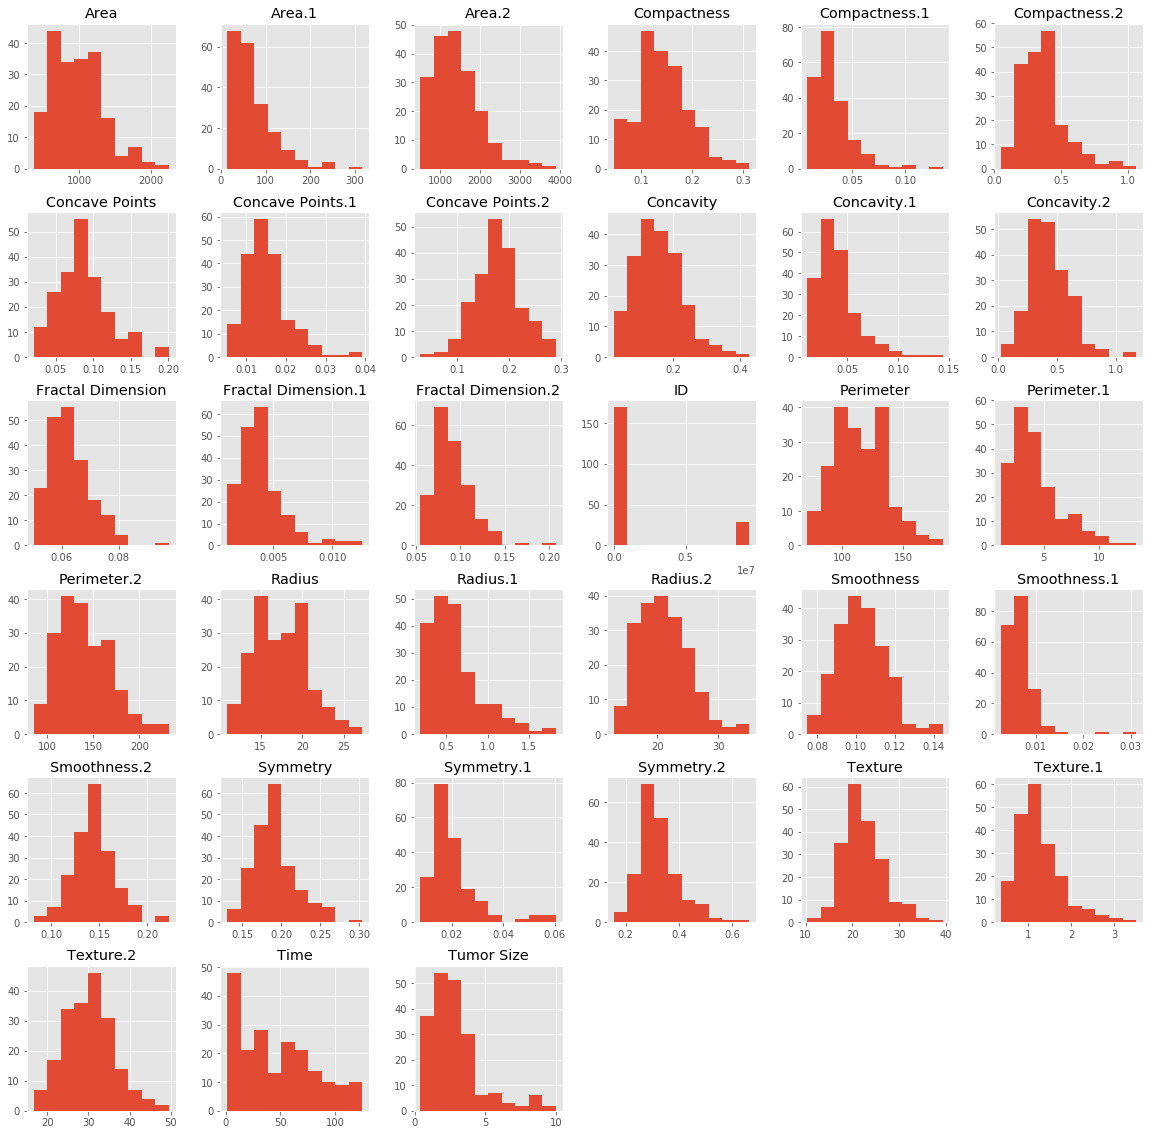

In [4]:
%matplotlib inline
plt.style.use('ggplot')
pd.DataFrame.hist(bcSet, figsize = [20,20]);

## Preprocessing

We know from the column descriptions provided with the datset and from viewing the data that there are two non-numeric columns:

In [5]:
# Take a look at the data

bcSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 35 columns):
ID                     198 non-null int64
Outcome                198 non-null object
Time                   198 non-null int64
Radius                 198 non-null float64
Texture                198 non-null float64
Perimeter              198 non-null float64
Area                   198 non-null float64
Smoothness             198 non-null float64
Compactness            198 non-null float64
Concavity              198 non-null float64
Concave Points         198 non-null float64
Symmetry               198 non-null float64
Fractal Dimension      198 non-null float64
Radius.1               198 non-null float64
Texture.1              198 non-null float64
Perimeter.1            198 non-null float64
Area.1                 198 non-null float64
Smoothness.1           198 non-null float64
Compactness.1          198 non-null float64
Concavity.1            198 non-null float64
Concave Points.1    

Note that the second and last column are type "object", these columns must have some nonnumeric values.

### Categorical Values

We will handle the categorical variable 'Outcome' using pandas get_dummy function, but many options exist including OneHotEncoder which will be used later to explore turning our 'Lymph node status' into an array.

In [6]:
# set each categorical variable to a dummy with pandas
labelEncoder = pd.get_dummies(bcSet['Outcome'],prefix='Outcome')

# join the encoded columns and drop the categorical 'Outcome column'
bcSet_numeric = bcSet.drop('Outcome', axis=1)
bcSet_numeric = bcSet_numeric.join(labelEncoder) # axis 1 is for column

# view column names
bcSet_numeric.columns

Index(['ID', 'Time', 'Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness',
       'Compactness', 'Concavity', 'Concave Points', 'Symmetry',
       'Fractal Dimension', 'Radius.1', 'Texture.1', 'Perimeter.1', 'Area.1',
       'Smoothness.1', 'Compactness.1', 'Concavity.1', 'Concave Points.1',
       'Symmetry.1', 'Fractal Dimension.1', 'Radius.2', 'Texture.2',
       'Perimeter.2', 'Area.2', 'Smoothness.2', 'Compactness.2', 'Concavity.2',
       'Concave Points.2', 'Symmetry.2', 'Fractal Dimension.2', 'Tumor Size',
       'Lymph node status', 'Outcome_N', 'Outcome_R'],
      dtype='object')

We can see here that the 'N' and 'R' variables were added and that the 'outcome' variable was removed. 

In [7]:
bcSet_numeric[['Outcome_N','Outcome_R']].head()

,Outcome_N,Outcome_R
0,1,0
1,1,0
2,1,0
3,1,0
4,0,1


### Missing Values

The variable 'Lymph node status' was also type 'object', explore why using value_counts

In [8]:
bcSet['Lymph node status'].value_counts()

0     87
1     35
2     17
4     10
13     6
7      6
?      4
3      4
9      4
6      3
11     3
15     3
27     2
10     2
8      2
20     2
5      2
21     1
17     1
18     1
24     1
16     1
14     1
Name: Lymph node status, dtype: int64

Look! There are 4 '?'

In [9]:
print([bcSet['ID'][i] for i,j in enumerate(bcSet['Lymph node status']) if bcSet['Lymph node status'][i] == '?'])
bcSet.iloc[0]

[844359, 854253, 877500, 947204]


ID                       119513
Outcome                       N
Time                         31
Radius                    18.02
Texture                    27.6
Perimeter                 117.5
Area                       1013
Smoothness              0.09489
Compactness              0.1036
Concavity                0.1086
Concave Points          0.07055
Symmetry                 0.1865
Fractal Dimension       0.06333
Radius.1                 0.6249
Texture.1                  1.89
Perimeter.1               3.972
Area.1                    71.55
Smoothness.1           0.004433
Compactness.1           0.01421
Concavity.1             0.03233
Concave Points.1       0.009854
Symmetry.1              0.01694
Fractal Dimension.1    0.003495
Radius.2                  21.63
Texture.2                 37.08
Perimeter.2               139.7
Area.2                     1436
Smoothness.2             0.1195
Compactness.2            0.1926
Concavity.2               0.314
Concave Points.2          0.117
Symmetry

In [10]:
# get the row number for the missing values
missingAtt = [i for i,j in enumerate(bcSet['Lymph node status']) if bcSet['Lymph node status'][i] == '?']

# create a new dataframe with just the missing values
bcSet_missing = bcSet_numeric.loc[missingAtt]

# create new dataframe without the missing values
bcSet_numeric = bcSet_numeric.drop(missingAtt)


We can check that the '?' rows have been removed:

In [11]:
bcSet_numeric['Lymph node status'].value_counts()

0     87
1     35
2     17
4     10
13     6
7      6
9      4
3      4
6      3
15     3
11     3
27     2
8      2
5      2
10     2
20     2
18     1
21     1
17     1
24     1
14     1
16     1
Name: Lymph node status, dtype: int64

#### Explore replacing the missing values with estimates made by regression models


In [12]:
bcSet_numeric['Lymph node status'] = pd.to_numeric(bcSet_numeric['Lymph node status'], errors='ignore')

In [13]:
# set the y to 'Lymph node status'
bcSet_numeric_y = bcSet_numeric['Lymph node status']

# set the X to everything but 'Lymph node status'
bcSet_numeric_X = bcSet_numeric.drop(['Lymph node status'], axis=1)

# remove the predicted value from our missing set
bcSet_missing_X = bcSet_missing.drop(['Lymph node status'], axis=1)

In [14]:
linearReg = LinearRegression()
ridgeReg = Ridge()

linearReg.fit(bcSet_numeric_X, bcSet_numeric_y)
ridgeReg.fit(bcSet_numeric_X, bcSet_numeric_y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [15]:
linearReg.predict(bcSet_missing_X)

array([-0.12359137, -0.95499606,  0.24437457,  3.36051288])

In [16]:
ridgeReg.predict(bcSet_missing_X)

array([-1.01053075,  1.60943479,  0.99158819,  2.503141  ])

Let's compare both of these to the mean and median of the 'Lymph node status'

In [17]:
print('{} \n\nMedian     {} \n\nMode       {}'.format(
    bcSet_numeric_y.describe(),bcSet_numeric_y.median(), bcSet_numeric_y.mode()))

count    194.000000
mean       3.211340
std        5.479276
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max       27.000000
Name: Lymph node status, dtype: float64 

Median     1.0 

Mode       0    0
dtype: int64


## Example for Categorical Variables by Defining Categorical Columns

Create a class that will encode given columns.

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
class EncodeDefCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, catCol):
        self.catCol = catCol # this is the variable passed to the class at instantiation
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        for  i in self.catCol:
            # set each categorical variable to a dummy with pandas
            labelEncoder = pd.get_dummies(X[i],prefix=i)
        
            # join the encoded columns and drop the categorical 'Outcome column'
            X_numeric = X.drop(i, axis=1)
        
        return X_numeric.join(labelEncoder)

In [19]:
# instantiate the class with categorical column name(s)

test = EncodeDefCategorical(['Outcome'])
test.catCol

['Outcome']

In [20]:
# fit returns class self

test.fit(bcSet)

EncodeDefCategorical(catCol=['Outcome'])

In [21]:
# transform returns the column of interest

test.transform(bcSet).head()

,ID,Time,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave Points,...,Smoothness.2,Compactness.2,Concavity.2,Concave Points.2,Symmetry.2,Fractal Dimension.2,Tumor Size,Lymph node status,Outcome_N,Outcome_R
0,119513,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,0.07055,...,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5,1,0
1,8423,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,0.14710,...,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2,1,0
2,842517,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,0.08180,...,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0,1,0
3,843483,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.10520,...,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0,1,0
4,843584,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.10430,...,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0,0,1


In [22]:
# create function that will confirm if a variable is a number
# code ref: https://stackoverflow.com/questions/354038/how-do-i-check-if-a-string-is-a-number-float

def is_number(s): 
    try:
        float(s)
        return True
    except ValueError:
        return False

## Example for Categorical Variables without Defining Columns

Create a class that will encode columns for categorical variables without the need to define each column.

In [23]:
# for testing add additional Outcome column and Lymph node status
bcSet_dup = bcSet.join(bcSet[['Outcome','Lymph node status']], rsuffix='_dup')

In [24]:
class EncodeCategorical(BaseEstimator, TransformerMixin):
        # nothing is passed to the class at instantiation
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        # select columns that are objects
        obCol = X.select_dtypes(include='object',).columns

        # identify which columns contain 100% non-numeric values
        catCol = [col for col in obCol if sum([is_number(var) for var in X[col]]) == 0]

        
        for  i in catCol:
            # set each categorical variable to a dummy with pandas
            labelEncoder = pd.get_dummies(X[i],prefix=i)
        
            # join the encoded columns and drop the categorical 'Outcome column'
            X = X.drop(i, axis=1).join(labelEncoder)
        
        return X

In [25]:
# instantiate the class with categorical column name(s)
test = EncodeCategorical()

# fit returns class self
test.fit(bcSet_dup)

EncodeCategorical()

In [26]:
# transform returns the dataframe with encoded categorical variables
# notice that the 'Outcome' column has been encoded while the 'Lymph node status' column is left alone

test.transform(bcSet_dup)[5:8]

,ID,Time,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave Points,...,Concave Points.2,Symmetry.2,Fractal Dimension.2,Tumor Size,Lymph node status,Lymph node status_dup,Outcome_N,Outcome_R,Outcome_dup_N,Outcome_dup_R
5,843786,77,12.75,15.29,84.6,502.7,0.11890,0.1569,0.16640,0.07666,...,0.1709,0.3485,0.11790,2.5,0,0,0,1,0,1
6,844359,60,18.98,19.61,124.4,1112.0,0.09087,0.1237,0.12130,0.08910,...,0.1922,0.2726,0.09581,1.5,?,?,1,0,1,0
7,844582,77,13.71,20.83,90.2,577.9,0.11890,0.1645,0.09366,0.05985,...,0.1556,0.3196,0.11510,4.0,10,10,0,1,0,1


## Example Pipeline for missing values

Create a class that will select the column containing our specific missing value '?'.

In [27]:
class MissingSelector(BaseEstimator, TransformerMixin):
    def __init__(self, mtype):
        self.mtype = mtype # this is the variable passed to the class at instantiation
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        missingCol = X.loc[X.eq(self.mtype).any(1), X.eq(self.mtype).any(0)].columns
        return X[missingCol]

In [28]:
# instantiate the class with our missing value of choice

test = MissingSelector('?')
test.mtype

'?'

In [29]:
# fit returns class self

test.fit(bcSet)

MissingSelector(mtype='?')

In [30]:
# transform returns the column of interest

test.transform(bcSet).head()

,Lymph node status
0,5
1,2
2,0
3,0
4,0


In [31]:
# This part of the pipeline has the intention of turning missing values into numbers
#    using different strategies such as mean / median replacement, and regression estimation.  

num_pipeline = Pipeline([
        ('selector', MissingSelector('?'))        
    ])

In [32]:
# Checkout the fit_transform

num_pipeline.fit_transform(bcSet).head()

,Lymph node status
0,5
1,2
2,0
3,0
4,0


## Impute Missing Values

Replace missing values using Mean, Median, Mode, or an sklearn model.predict().

In [33]:
from collections import defaultdict
import statistics
class ImputeMissing(BaseEstimator, TransformerMixin):
    def __init__(self, mtype, strategy):
        self.mtype = mtype # this is the variable passed to the class at instantiation
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        #find rows with missing values
        missingCol = X.loc[X.eq(self.mtype).any(1), X.eq(self.mtype).any(0)].columns

        for z in range(len(missingCol)):
            col = missingCol[z]
            # get the row number for the missing values
            missingAtt = [i for i,j in enumerate(X[col]) if X[col][i] == self.mtype]

            # create a new dataframe with just the missing values
            X_missing = X.loc[missingAtt]

            # create new dataframe without the missing values
            X_numeric = X.drop(missingAtt)
            
            # define options for descriptive statistic
            optionStats = {'mean': pd.to_numeric(X_numeric[col], errors='coerce').mean(),
                            'zero': 0, 
                            'mode': statistics.mode(X_numeric[col])}
            
            # define options for sklearn models
            optionModel = {'linear': LinearRegression(),
                            'ridge': Ridge(),
                            'knn': neighbors.KNeighborsClassifier(n_jobs=-1, weights="distance", p=1, n_neighbors=7)
                          }
            
            if self.strategy in optionStats:
                 # replace missing values with defined descriptive statistic
                X_missing[col].replace({self.mtype: optionStats[self.strategy]}, inplace=True)
                
            elif self.strategy in optionModel:
                # initialize model
                model = optionModel[self.strategy]
                
                # fit model
                model.fit(X_numeric.drop([col], axis=1), X_numeric[col])
                
                # replace missing values with prediction
                X_missing[col] = model.predict(X_missing.drop([col], axis=1))
                
            # add rows with missing values back to whole dataset
            X_numeric = X_numeric.append(X_missing).sort_index()
            
        return X_numeric


#### Check the results

Row 6 was a missing value, we can see it has been replaced.

In [34]:
bcSet[['ID','Outcome','Lymph node status']][5:8]

,ID,Outcome,Lymph node status
5,843786,R,0
6,844359,N,?
7,844582,R,10


In [35]:
# This test has to run the whole Pipeline because the categorical column will cause an error

num_pipeline = Pipeline([
        ('encoder', EncodeCategorical()),
        ('imputer', ImputeMissing('?','ridge'))
    ])

demo = num_pipeline.fit_transform(bcSet)
demo[['ID','Outcome_N','Outcome_R','Lymph node status']][5:8]

,ID,Outcome_N,Outcome_R,Lymph node status
5,843786,0,1,0
6,844359,1,0,-1.01053
7,844582,0,1,10


In [36]:
# This test has to run the whole Pipeline because the categorical column will cause an error

num_pipeline = Pipeline([
        ('encoder', EncodeCategorical()),
        ('imputer', ImputeMissing('?','knn'))
    ])

demo = num_pipeline.fit_transform(bcSet)
demo[['ID','Outcome_N','Outcome_R','Lymph node status']][5:8]

,ID,Outcome_N,Outcome_R,Lymph node status
5,843786,0,1,0
6,844359,1,0,0
7,844582,0,1,10


In [37]:
# This test is running the imputer without calling an sklearn model which does not
# need the the categorical column to be encoded

test = ImputeMissing('?','mean')
test.transform(bcSet)[5:8][['Lymph node status']]

,Lymph node status
5,0
6,3.21134
7,10


## Preprocessing Pipeline

In [38]:
num_pipeline = Pipeline([
        ('encoder', EncodeCategorical()),
        ('imputer', ImputeMissing('?','mean'))
    ])

In [39]:
demo = num_pipeline.fit_transform(bcSet)
demo[['ID','Outcome_N','Outcome_R','Lymph node status']][5:8]

,ID,Outcome_N,Outcome_R,Lymph node status
5,843786,0,1,0
6,844359,1,0,3.21134
7,844582,0,1,10


### Full Pipeline

.. to come

In [40]:
# OneHotEncoder for later
labelEncoder = LabelEncoder()
hotEncoder = OneHotEncoder()
catEncode = hotEncoder.fit_transform(labelEncoder.fit_transform(bcSet['Outcome']).reshape(-1,1))

catEncode[:5].toarray()

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])